# Assignment 2 of ECE657A:

## Team members:


### Hadi Nekoeiqachkanloo (Waterloo ID: 20727088)
### Benyamin Ghojogh (Waterloo ID: 20743301)

#### Import packages:

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.io import loadmat
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import warnings
from sklearn.metrics import precision_recall_fscore_support
import timeit
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
import collections

References:

KNN: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

Cross validation: http://scikit-learn.org/stable/modules/cross_validation.html

SVM :http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

RandomForest :http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Neural_networks: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

Accuracy score: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

F measure:  http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

timeit: https://stackoverflow.com/questions/5622976/how-do-you-calculate-program-run-time-in-python

Decision tree: http://scikit-learn.org/stable/modules/tree.html

classification_report: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

StratifiedShuffleSplit: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html

collections (for finding frequency in list): https://stackoverflow.com/questions/2161752/how-to-count-the-frequency-of-the-elements-in-a-list

#### Settings:

Please put the datasets in the the same folder where the code file exists.

In [137]:
path_dataset_A = './bank-additional.csv'
path_dataset_B = './DataDNA.mat'

#### display numpy array in beautiful form:

The following function converts the numpy array into pandas DataFrame, and then display it beautifully:

In [138]:
def disp_array_beautiful(numpy_array, number_of_rows=10):
    data_dataFrame = pd.DataFrame(data=numpy_array, columns=None)  # convert numpy array to pandas data frame
    display(data_dataFrame.head(number_of_rows))  # displaying a portion of the dataset

Reading datasets and displaying a portion of it:

# Part I:

## Question 1:

Loading dataset A and displaying it (features of dataset):

In [139]:
dataA = pd.read_csv(path_dataset_A, delimiter=';')
data_to_display = dataA.T  # taking just the first 10 rows
dataA_name_of_features = list(dataA.columns)[:-1]
data_to_display  # display a potion of data

,0,1,2,3,4,5,6,7,8,9,...,4109,4110,4111,4112,4113,4114,4115,4116,4117,4118
age,30,39,25,38,47,32,32,41,31,35,...,63,53,30,31,31,30,39,27,58,34
job,blue-collar,services,services,services,admin.,services,admin.,entrepreneur,services,blue-collar,...,retired,housemaid,technician,technician,admin.,admin.,admin.,student,admin.,management
marital,married,single,married,married,married,single,single,married,divorced,married,...,married,divorced,married,single,single,married,married,single,married,single
education,basic.9y,high.school,high.school,basic.9y,university.degree,university.degree,university.degree,university.degree,professional.course,basic.9y,...,high.school,basic.6y,university.degree,professional.course,university.degree,basic.6y,high.school,high.school,high.school,high.school
default,no,no,no,no,no,no,no,unknown,no,unknown,...,no,unknown,no,no,no,no,no,no,no,no
housing,yes,no,yes,unknown,yes,no,yes,yes,no,no,...,no,unknown,no,yes,yes,yes,yes,no,no,yes
loan,no,no,no,unknown,no,no,no,no,no,no,...,no,unknown,yes,no,no,yes,no,no,no,no
contact,cellular,telephone,telephone,telephone,cellular,cellular,cellular,cellular,cellular,telephone,...,cellular,telephone,cellular,cellular,cellular,cellular,telephone,cellular,cellular,cellular
month,may,may,jun,jun,nov,sep,sep,nov,nov,may,...,oct,may,jun,nov,nov,jul,jul,may,aug,nov
day_of_week,fri,fri,wed,fri,mon,thu,mon,mon,tue,thu,...,wed,fri,fri,thu,thu,thu,fri,mon,fri,wed


#### exclude labels from dataset:

We convert the pandas dataframe to 2D numpy array which can be interpreted as a matrix. We also read the names of (numeric) columns and store it for future use.

In [140]:
# features:
dataA_excluding_labels = dataA.iloc[:, :-1]  # convert to numpy array
dataA_labels = dataA.iloc[:, -1]
dataA = dataA_excluding_labels

#### detecting missing data:

The dataset A contains two types of problems: 1- missing values (unknown) 2- outliers.

In the following section, we detect the missing data in the columns of dataset. We count the number of missing values in every attribute (column of dataset) and then compute the fraction of missing values in the different attributes. We call this fraction as fraction_of_missing_data_in_attribute.

#### Finding fraction of invalid data in each column:

In [141]:
# https://stackoverflow.com/questions/2161752/how-to-count-the-frequency-of-the-elements-in-a-list

dataA_array = dataA.values
number_of_samples = dataA_array.shape[0]
number_of_features = dataA_array.shape[1]
fraction_of_invalid_data = np.zeros(number_of_features)
mode_in_features = []
for feature_index in range(number_of_features):
    column = dataA_array[:, feature_index]
    counter = collections.Counter(column)
    # feature_values = set(column)  # non-repatative feature values
    feature_keys = list(counter.keys())  # non-repatative feature values
    feature_keys_frequency = list(counter.values())
    mode_in_features.append(counter.most_common(1)[0][0])
    for feature_key_index in range(len(feature_keys)):
        feature_key = feature_keys[feature_key_index]
        if feature_key == 'unknown':
            fraction_of_invalid_data[feature_index] = 100 * feature_keys_frequency[feature_key_index] / number_of_samples
        

In [142]:
for feature_index in range(number_of_features):
    print('fraction of invalid data in feature "' + \
          dataA_name_of_features[feature_index] + '": ' + \
          str(round(fraction_of_invalid_data[feature_index], 2)) + ' %')

fraction of invalid data in feature "age": 0.0 %
fraction of invalid data in feature "job": 0.95 %
fraction of invalid data in feature "marital": 0.27 %
fraction of invalid data in feature "education": 4.05 %
fraction of invalid data in feature "default": 19.5 %
fraction of invalid data in feature "housing": 2.55 %
fraction of invalid data in feature "loan": 2.55 %
fraction of invalid data in feature "contact": 0.0 %
fraction of invalid data in feature "month": 0.0 %
fraction of invalid data in feature "day_of_week": 0.0 %
fraction of invalid data in feature "duration": 0.0 %
fraction of invalid data in feature "campaign": 0.0 %
fraction of invalid data in feature "pdays": 0.0 %
fraction of invalid data in feature "previous": 0.0 %
fraction of invalid data in feature "poutcome": 0.0 %
fraction of invalid data in feature "emp.var.rate": 0.0 %
fraction of invalid data in feature "cons.price.idx": 0.0 %
fraction of invalid data in feature "cons.conf.idx": 0.0 %
fraction of invalid data in

####  fixing missing data:
This fraction fraction_of_missing_data_in_attribute is in range [0,1].

If this fraction is 0, it means that the column (attribute) does not have any missing value, and thus we take the attribute without doing anything to it.

If this fraction is close to 1 (>= 0.5), it means that the column (attribute) includes many missing values and therefore we remove that column completely.

If the fraction of an attribute is in range (0,0.1], it means that its missing value is not a lot and thus we can fill the missing values of the attribute with the average of the known values in that attribute.

#### fixing invalid data in each column:

In [143]:
dataA_purified = dataA
dataA_purified_array = dataA_purified.values
columns_to_be_removed = []
for feature_index in range(number_of_features):
    if fraction_of_invalid_data[feature_index] > 15:
        columns_to_be_removed.append(feature_index)
    elif fraction_of_invalid_data[feature_index] != 0:
        column = dataA_purified.values[:, feature_index]
        dataA_purified_array[column == 'unknown', feature_index] = mode_in_features[feature_index]
        dataA_purified.iloc[:, :] = dataA_purified_array
dataA_purified = dataA_purified.drop(dataA_purified.columns[columns_to_be_removed], axis=1)
dataA_name_of_features = [x for i,x in enumerate(dataA_name_of_features) if i not in columns_to_be_removed]  # omit the names of removed features
dataA_purified_array = dataA_purified.values
dataA_purified.T

,0,1,2,3,4,5,6,7,8,9,...,4109,4110,4111,4112,4113,4114,4115,4116,4117,4118
age,30,39,25,38,47,32,32,41,31,35,...,63,53,30,31,31,30,39,27,58,34
job,blue-collar,services,services,services,admin.,services,admin.,entrepreneur,services,blue-collar,...,retired,housemaid,technician,technician,admin.,admin.,admin.,student,admin.,management
marital,married,single,married,married,married,single,single,married,divorced,married,...,married,divorced,married,single,single,married,married,single,married,single
education,basic.9y,high.school,high.school,basic.9y,university.degree,university.degree,university.degree,university.degree,professional.course,basic.9y,...,high.school,basic.6y,university.degree,professional.course,university.degree,basic.6y,high.school,high.school,high.school,high.school
housing,yes,no,yes,yes,yes,no,yes,yes,no,no,...,no,yes,no,yes,yes,yes,yes,no,no,yes
loan,no,no,no,no,no,no,no,no,no,no,...,no,no,yes,no,no,yes,no,no,no,no
contact,cellular,telephone,telephone,telephone,cellular,cellular,cellular,cellular,cellular,telephone,...,cellular,telephone,cellular,cellular,cellular,cellular,telephone,cellular,cellular,cellular
month,may,may,jun,jun,nov,sep,sep,nov,nov,may,...,oct,may,jun,nov,nov,jul,jul,may,aug,nov
day_of_week,fri,fri,wed,fri,mon,thu,mon,mon,tue,thu,...,wed,fri,fri,thu,thu,thu,fri,mon,fri,wed
duration,487,346,227,17,58,128,290,44,68,170,...,1386,85,131,155,463,53,219,64,528,175


#### detecting outliers:
In the following section, we detect the outliers in the columns (attributes) of dataset.

First off, we compute the standard deviation (std) of each attribute (column of dataset).

Then, in every column (attribute), if the distance of the value and the mean (average) of the attribute is more than (3 std), we take that value as an outlier. The reason of this has a statistical support especially in Gaussian probability distribution where only 0.26% of the data falls outside the range of |3 * std|. (for proof, please see https://www.mathsisfun.com/data/standard-normal-distribution-table.html)

In [144]:
number_of_features = dataA_purified_array.shape[1]
number_of_samples = dataA_purified_array.shape[0]
std_of_features = [None] * number_of_features
mean_of_features = [None] * number_of_features
outlier_mask = np.zeros(dataA_purified_array.shape)
for feature_index in range(number_of_features):
    feature = dataA_purified_array[:, feature_index]
    if type(feature[0]) is not str:
        std_of_features[feature_index] = np.std(feature)
        mean_of_features[feature_index] = np.mean(feature)
        # analyzing every sample of attribute:
        for sample_index in range(number_of_samples):
            if abs(feature[sample_index] - mean_of_features[feature_index]) > (3 * std_of_features[feature_index]):
                # it is outlier
                outlier_mask[sample_index, feature_index] = 1

Now, we calculate how many of features of every sample is outlier and find the fraction named "fraction_of_outlier_data_in_sample". Then, we plot histogram (having 30 bins) of samples with respect to the fractions in order to emperically find the best thresholds for fixing outliers.

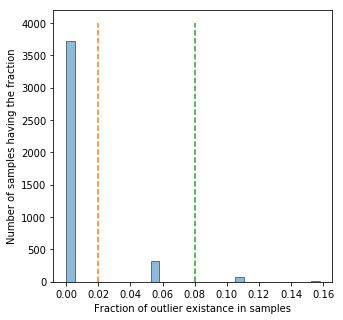

In [145]:
fraction_of_outlier_data_in_sample = [None] * number_of_samples
for sample_index in range(number_of_samples):
    fraction_of_outlier_data_in_sample[sample_index] = sum(outlier_mask[sample_index, :]) / number_of_features
plt.hist(fraction_of_outlier_data_in_sample, bins=30, alpha=0.5, edgecolor='k')
plt.xlabel('Fraction of outlier existance in samples')
plt.ylabel('Number of samples having the fraction')
threshold1_of_outlier_fraction = 0.02
threshold2_of_outlier_fraction = 0.08
plt.plot([threshold1_of_outlier_fraction, threshold1_of_outlier_fraction], [0, 4000], '--')
plt.plot([threshold2_of_outlier_fraction, threshold2_of_outlier_fraction], [0, 4000], '--')
plt.rcParams['figure.figsize'] = (5,5) 
plt.show()

As can be seen in the above histogram:

1- Most of the samples have fraction in range [0, 0.02]. Therefore, we keep those samples.

2- Moreover, there exist some noticable samples having fractions more than 0.08, which means they are significantly outliers. Thus, we completely remove those samples from the dataset.

3- Finally, we alter the samples having fractions in range [0.02, 0.08] by replacing their outlier attributes by their saturations of the corresponding column. In other words:

3-a- if the outlier attribute in the sample is greater than (3 std_of_attribute + mean_of_attribute), we replace it by (3 std_of_attribute + mean_of_attribute).
3-b- if the outlier attribute in the sample is less than (mean_of_attribute - 3 std_of_attribute), we replace it by (mean_of_attribute - 3 std_of_attribute).

In [146]:
number_of_features = dataA_purified_array.shape[1]
number_of_samples = dataA_purified_array.shape[0]
dataA_purified2_array = np.empty([0, number_of_features])
for sample_index in range(number_of_samples):
    if fraction_of_outlier_data_in_sample[sample_index] < threshold1_of_outlier_fraction:
        dataA_purified2_array = np.vstack([dataA_purified2_array, dataA_purified_array[sample_index, :]])
    elif fraction_of_outlier_data_in_sample[sample_index] < threshold2_of_outlier_fraction:
        dataA_purified2_array = np.vstack([dataA_purified2_array, dataA_purified_array[sample_index, :]])
        # saturate the outlier attributes:
        current_sample_index = dataA_purified2_array.shape[0] - 1  # pick the last row which was added recently
        for feature_index in range(number_of_features):
            if outlier_mask[sample_index, feature_index] == 1:   # if the feature is not categorical
                feature = dataA_purified_array[:, feature_index]
                mean_of_features = np.mean(feature)
                std_of_features = np.std(feature)
                if (feature[sample_index] - mean_of_features) > (3 * std_of_features):
                    # saturate to upper bound:
                    dataA_purified2_array[current_sample_index, feature_index] = \
                        mean_of_features + (3 * std_of_features) 
                elif (mean_of_features - feature[sample_index]) > (3 * std_of_features):
                    # saturate to lower bound:
                    dataA_purified2_array[current_sample_index, feature_index] = \
                        mean_of_features - (3 * std_of_features) 
                else:
                    pass # do nothing
    else:
        pass # do nothing (exclude this sample)

As can be seen in the following, we firstly removed some attributes having lots of missing values (81 attributes are reduced to 78).

Thereafter, we removed some samples having lots of outlier attributes (19000 samples are reduced to 18214).

Notice: purifying missing values should be done in columns (attributes) and purifying outliers should be done in rows (samples) because being outlier is a charactersitic of samples and not attributes.

In [147]:
print('The original size of dataset: ' \
      + '(' + str(dataA.shape[0]) + ', ' + str(dataA.shape[1]) + ')')

The original size of dataset: (4119, 20)


In [148]:
print('new size of dataset after fixing data missing: ' \
      + '(' + str(dataA_purified_array.shape[0]) + ', ' + str(dataA_purified_array.shape[1]) + ')')

new size of dataset after fixing data missing: (4119, 19)


In [149]:
print('new size of dataset after fixing data missing and outliers: ' \
      + '(' + str(dataA_purified2_array.shape[0]) + ', ' + str(dataA_purified2_array.shape[1]) + ')')

new size of dataset after fixing data missing and outliers: (4040, 19)


#### Convert the entire dataset to numeric values:

I extract the labels (the last column of dataset). But the labels are non-numeric (are categorical). So, I firstly convert the dataset to numeric dataset (convert every categorical column to several numeric columns), and then take the last column (which contains the numeric labels). Note that drop_first=True means that there is no need to two columns for labels yes and no and one column having 0 and 1 suffices for it.

In [183]:
names_of_categorical_features = []
for feature_index in range(dataA_purified2_array.shape[1]):
    if type(dataA_purified2_array[0, feature_index]) is str:
        names_of_categorical_features.append(dataA_name_of_features[feature_index])

In [187]:
dataA_fea_categorical = pd.DataFrame(data=dataA_purified2_array, columns=dataA_name_of_features)
dataA_fea = pd.get_dummies(data=dataA_fea_categorical, drop_first=True, columns=names_of_categorical_features)

dataA_gnd = pd.get_dummies(data=dataA_labels, drop_first=True)

In [188]:
# displaying a portion of features and labels:
print('A portion of features of dataset:')
disp_array_beautiful(dataA_fea, number_of_rows=10)
print('A portion of labels of dataset:')
disp_array_beautiful(dataA_gnd, number_of_rows=10)

A portion of features of dataset:


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,30,487,2,999,0,-1.8,92.893,-46.2,1.313,5099.1,...,1,0,0,0,0,0,0,0,1,0
1,39,346,4,999,0,1.1,93.994,-36.4,4.855,5191,...,1,0,0,0,0,0,0,0,1,0
2,25,227,1,999,0,1.4,94.465,-41.8,4.962,5228.1,...,0,0,0,0,0,0,0,1,1,0
3,38,17,3,999,0,1.4,94.465,-41.8,4.959,5228.1,...,0,0,0,0,0,0,0,0,1,0
4,47,58,1,999,0,-0.1,93.2,-42,4.191,5195.8,...,0,1,0,0,1,0,0,0,1,0
5,32,128,3,999,1.81551,-1.1,94.199,-37.5,0.884,4963.6,...,0,0,0,1,0,1,0,0,0,0
6,32,290,4,999,0,-1.1,94.199,-37.5,0.879,4963.6,...,0,0,0,1,1,0,0,0,1,0
7,41,44,2,999,0,-0.1,93.2,-42,4.191,5195.8,...,0,1,0,0,1,0,0,0,1,0
8,31,68,1,999,1,-0.1,93.2,-42,4.153,5195.8,...,0,1,0,0,0,0,1,0,0,0
9,35,170,1,999,0,1.1,93.994,-36.4,4.855,5191,...,1,0,0,0,0,1,0,0,1,0


A portion of labels of dataset:


,yes
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


#### Convert dataset from pandas dataframe to numpy array:

We convert the pandas dataframe to 2D numpy array which can be interpreted as a matrix. We also read the names of (numeric) columns and store it for future use.

In [190]:
# features:
dataA_fea = dataA_purified2_array
# labels:
dataA_gnd = (dataA_categorical2numeric.iloc[:, -1].values).ravel() # convert to list
# name of features:
name_of_features = (dataA_categorical2numeric.columns).ravel()

# displaying a portion of features and labels:
print('A portion of features of dataset:')
disp_array_beautiful(dataA_fea, number_of_rows=10)
print('A portion of labels of dataset:')
disp_array_beautiful(dataA_gnd, number_of_rows=10)

A portion of features of dataset:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,30,blue-collar,married,basic.9y,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1
1,39,services,single,high.school,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191
2,25,services,married,high.school,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1
3,38,services,married,basic.9y,yes,no,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1
4,47,admin.,married,university.degree,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.2,-42,4.191,5195.8
5,32,services,single,university.degree,no,no,cellular,sep,thu,128,3,999,1.81551,failure,-1.1,94.199,-37.5,0.884,4963.6
6,32,admin.,single,university.degree,yes,no,cellular,sep,mon,290,4,999,0,nonexistent,-1.1,94.199,-37.5,0.879,4963.6
7,41,entrepreneur,married,university.degree,yes,no,cellular,nov,mon,44,2,999,0,nonexistent,-0.1,93.2,-42,4.191,5195.8
8,31,services,divorced,professional.course,no,no,cellular,nov,tue,68,1,999,1,failure,-0.1,93.2,-42,4.153,5195.8
9,35,blue-collar,married,basic.9y,no,no,telephone,may,thu,170,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191


A portion of labels of dataset:


,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


## Question 2:

#### partitioning dataset into training and testing sets:

In the following, we define a function which divides our data and its labels to training data and test data with given fraction.
We use this function in different places of codes and questions.

In [163]:
def partition_dataset_into_training_and_testing_sets(dataset, labels, fraction_of_training_set):
    number_of_samples = dataset.shape[0]
    number_of_training_samples = int(fraction_of_training_set*number_of_samples)
    mask_train = np.zeros([number_of_samples])
    indices_of_training_samples = np.random.choice(range(number_of_samples), number_of_training_samples, replace=False) 
    # in the above function "np.random.choice": replace=False means no replacement
    mask_train[indices_of_training_samples] = 1
    mask_train = mask_train.astype(bool)
    training_samples = dataset[mask_train, :]
    testing_samples = dataset[np.logical_not(mask_train), :]
    training_labels = labels[mask_train]
    testing_labels = labels[np.logical_not(mask_train)]
    return training_samples, testing_samples, training_labels.ravel(), testing_labels.ravel()

In [207]:
training_samples, testing_samples, training_labels, testing_labels = \
    partition_dataset_into_training_and_testing_sets(dataset=dataA_fea, labels=dataA_gnd, fraction_of_training_set=0.7)

## Question 3:

In [208]:
# Decision_tree Classifier
clf_Decision_tree = tree.DecisionTreeClassifier()
clf_Decision_tree.fit(training_samples, training_labels.ravel())
precited_labels_Decision_tree = clf_Decision_tree.predict(testing_samples)
accuracy_Decision_tree = accuracy_score(y_true=testing_labels, y_pred=precited_labels_Decision_tree)

# RandomForest Classifier
clf_RandomForest = RandomForestClassifier(min_samples_leaf=1, min_samples_split =10, max_features=10)
clf_RandomForest.fit(training_samples, training_labels.ravel())
precited_labels_RandomForest = clf_RandomForest.predict(testing_samples)
accuracy_RandomForest = accuracy_score(y_true=testing_labels, y_pred=precited_labels_RandomForest)

# NeuralNetworks Classifier
clf_NeuralNetworks = MLPClassifier(activation='tanh', solver='sgd',hidden_layer_sizes=(10,))
clf_NeuralNetworks.fit(training_samples, training_labels.ravel())  
precited_labels_NN = clf_NeuralNetworks.predict(testing_samples)
accuracy_NN = accuracy_score(y_true=testing_labels, y_pred=precited_labels_NN)

print('Accuracy rate of Decision_tree: ' + str(accuracy_Decision_tree * 100))
print('Accuracy rate of RandomForest: ' + str(accuracy_RandomForest * 100))
print('Accuracy rate of Neural Network: ' + str(accuracy_NN * 100))

Accuracy rate of Decision_tree: 89.1585760518
Accuracy rate of RandomForest: 90.4530744337
Accuracy rate of Neural Network: 88.430420712


## Question 4:

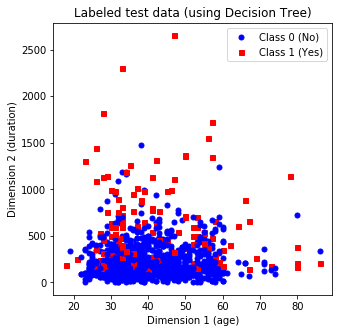

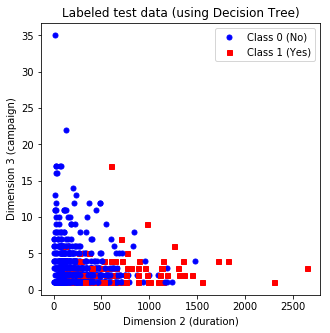

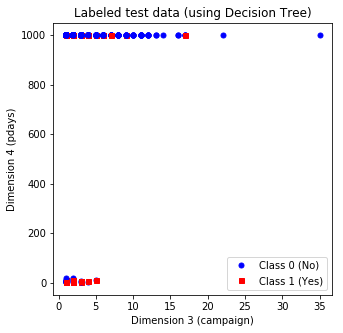

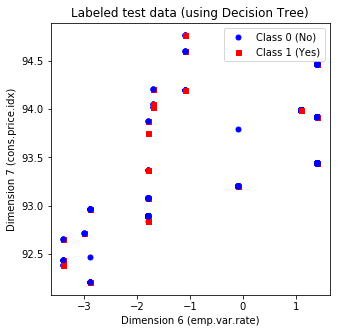

In [191]:
dimensions_list = [[0,1], [1,2], [2,3], [5,6]]
for dimensions in dimensions_list:
    dimension1 = dimensions[0]
    dimension2 = dimensions[1]
    for sample_index in range(testing_samples.shape[0]):
        if precited_labels_Decision_tree[sample_index] == 0:
            color = 'b'
            marker = 'o'
            plt0, = plt.plot(testing_samples[sample_index, dimension1], testing_samples[sample_index, dimension2], marker, \
                 color=color, markerfacecolor=color, markersize=5, label='Class '+str(0)+' (No)')
        else:
            color = 'r'
            marker = 's'
            plt1, = plt.plot(testing_samples[sample_index, dimension1], testing_samples[sample_index, dimension2], marker, \
                 color=color, markerfacecolor=color, markersize=5, label='Class '+str(1)+' (Yes)')
    plt.xlabel('Dimension '+ str(dimension1+1) + ' ('+ name_of_features[dimension1] + ')')
    plt.ylabel('Dimension '+ str(dimension2+1) + ' ('+ name_of_features[dimension2] + ')')
    axes = plt.gca()
    # axes.set_ylim([25, 35])
    plt.rcParams['figure.figsize'] = (5,5) 
    plt.title('Labeled test data (using Decision Tree)')
    plt.legend(handles = [plt0, plt1])
    plt.show()

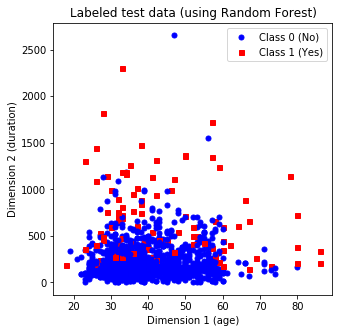

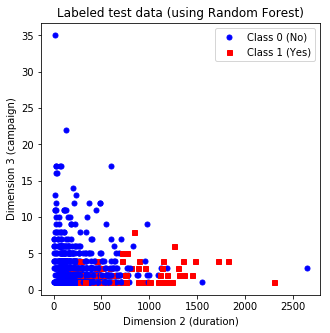

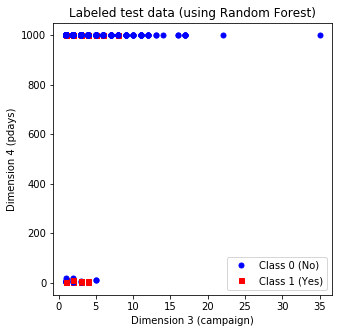

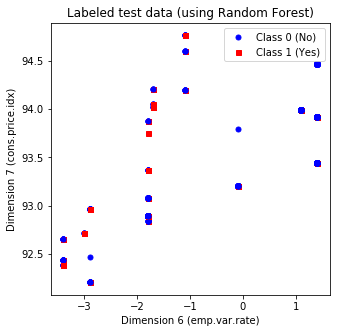

In [190]:
dimensions_list = [[0,1], [1,2], [2,3], [5,6]]
for dimensions in dimensions_list:
    dimension1 = dimensions[0]
    dimension2 = dimensions[1]
    for sample_index in range(testing_samples.shape[0]):
        if precited_labels_RandomForest[sample_index] == 0:
            color = 'b'
            marker = 'o'
            plt0, = plt.plot(testing_samples[sample_index, dimension1], testing_samples[sample_index, dimension2], marker, \
                 color=color, markerfacecolor=color, markersize=5, label='Class '+str(0)+' (No)')
        else:
            color = 'r'
            marker = 's'
            plt1, = plt.plot(testing_samples[sample_index, dimension1], testing_samples[sample_index, dimension2], marker, \
                 color=color, markerfacecolor=color, markersize=5, label='Class '+str(1)+' (Yes)')
    plt.xlabel('Dimension '+ str(dimension1+1) + ' ('+ name_of_features[dimension1] + ')')
    plt.ylabel('Dimension '+ str(dimension2+1) + ' ('+ name_of_features[dimension2] + ')')
    axes = plt.gca()
    # axes.set_ylim([25, 35])
    plt.rcParams['figure.figsize'] = (5,5) 
    plt.title('Labeled test data (using Random Forest)')
    plt.legend(handles = [plt0, plt1])
    plt.show()

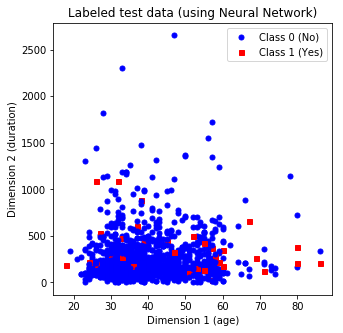

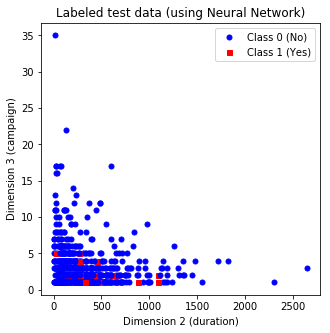

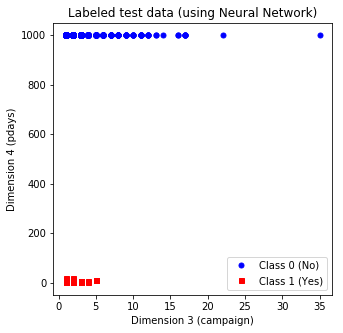

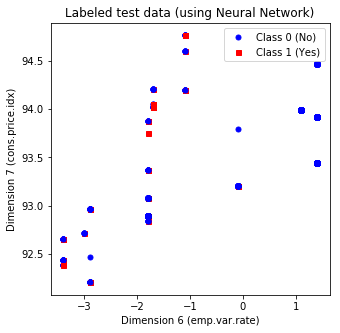

In [189]:
dimensions_list = [[0,1], [1,2], [2,3], [5,6]]
for dimensions in dimensions_list:
    dimension1 = dimensions[0]
    dimension2 = dimensions[1]
    for sample_index in range(testing_samples.shape[0]):
        if precited_labels_NN[sample_index] == 0:
            color = 'b'
            marker = 'o'
            plt0, = plt.plot(testing_samples[sample_index, dimension1], testing_samples[sample_index, dimension2], marker, \
                 color=color, markerfacecolor=color, markersize=5, label='Class '+str(0)+' (No)')
        else:
            color = 'r'
            marker = 's'
            plt1, = plt.plot(testing_samples[sample_index, dimension1], testing_samples[sample_index, dimension2], marker, \
                 color=color, markerfacecolor=color, markersize=5, label='Class '+str(1)+' (Yes)')
    plt.xlabel('Dimension '+ str(dimension1+1) + ' ('+ name_of_features[dimension1] + ')')
    plt.ylabel('Dimension '+ str(dimension2+1) + ' ('+ name_of_features[dimension2] + ')')
    axes = plt.gca()
    # axes.set_ylim([25, 35])
    plt.rcParams['figure.figsize'] = (5,5) 
    plt.title('Labeled test data (using Neural Network)')
    plt.legend(handles = [plt0, plt1])
    plt.show()

## Question 5:

In [200]:
target_names = ['class 0 (No)', 'class 1 (Yes)']

table_report_Decision_tree = classification_report(y_true=testing_labels, y_pred=precited_labels_Decision_tree, target_names=target_names)
print(table_report_Decision_tree)
accuracy_Decision_tree = accuracy_score(y_true=testing_labels, y_pred=precited_labels_Decision_tree)
print('accuracy: ' + str(accuracy_Decision_tree))
print('===================================')

table_report_RandomForest = classification_report(y_true=testing_labels, y_pred=precited_labels_RandomForest, target_names=target_names)
print(table_report_RandomForest)
accuracy_RandomForest = accuracy_score(y_true=testing_labels, y_pred=precited_labels_RandomForest)
print('accuracy: ' + str(accuracy_RandomForest))
print('===================================')

table_report_NN = classification_report(y_true=testing_labels, y_pred=precited_labels_NN, target_names=target_names)
print(table_report_NN)
accuracy_NN = accuracy_score(y_true=testing_labels, y_pred=precited_labels_NN)
print('accuracy: ' + str(accuracy_NN))

               precision    recall  f1-score   support

 class 0 (No)       0.95      0.94      0.95      1113
class 1 (Yes)       0.52      0.59      0.56       123

  avg / total       0.91      0.91      0.91      1236

accuracy: 0.905339805825
               precision    recall  f1-score   support

 class 0 (No)       0.94      0.96      0.95      1113
class 1 (Yes)       0.57      0.46      0.51       123

  avg / total       0.90      0.91      0.91      1236

accuracy: 0.911812297735
               precision    recall  f1-score   support

 class 0 (No)       0.92      0.98      0.95      1113
class 1 (Yes)       0.63      0.25      0.36       123

  avg / total       0.89      0.91      0.89      1236

accuracy: 0.911003236246


## Question 6:

## Question 7:

In [212]:
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3)
for train_index, test_index in sss.split(X=dataA_fea, y=dataA_gnd):
    training_data, testing_data = dataA_fea[train_index], dataA_fea[test_index]
    training_labels, testing_labels = dataA_gnd[train_index], dataA_gnd[test_index]

ratio_of_all_class0 = sum(dataA_gnd == 0) / len(dataA_gnd)
ratio_of_all_class1 = sum(dataA_gnd == 1) / len(dataA_gnd)
ratio_of_training_class0 = sum(training_labels == 0) / len(training_labels)
ratio_of_training_class1 = sum(training_labels == 1) / len(training_labels)
ratio_of_testing_class0 = sum(testing_labels == 0) / len(testing_labels)
ratio_of_testing_class1 = sum(testing_labels == 1) / len(testing_labels)

print(ratio_of_all_class0)
print(ratio_of_all_class1)
print(ratio_of_training_class0)
print(ratio_of_training_class1)
print(ratio_of_testing_class0)
print(ratio_of_testing_class1)
    
# Decision_tree Classifier
clf_Decision_tree = tree.DecisionTreeClassifier()
clf_Decision_tree.fit(training_samples, training_labels.ravel())
precited_labels_Decision_tree = clf_Decision_tree.predict(testing_samples)
accuracy_Decision_tree = accuracy_score(y_true=testing_labels, y_pred=precited_labels_Decision_tree)

# RandomForest Classifier
clf_RandomForest = RandomForestClassifier(min_samples_leaf=1, min_samples_split =10, max_features=10)
clf_RandomForest.fit(training_samples, training_labels.ravel())
precited_labels_RandomForest = clf_RandomForest.predict(testing_samples)
accuracy_RandomForest = accuracy_score(y_true=testing_labels, y_pred=precited_labels_RandomForest)

# NeuralNetworks Classifier
clf_NeuralNetworks = MLPClassifier(activation='tanh', solver='sgd',hidden_layer_sizes=(10,))
clf_NeuralNetworks.fit(training_samples, training_labels.ravel())  
precited_labels_NN = clf_NeuralNetworks.predict(testing_samples)
accuracy_NN = accuracy_score(y_true=testing_labels, y_pred=precited_labels_NN)

print('Accuracy rate of Decision_tree: ' + str(accuracy_Decision_tree * 100))
print('Accuracy rate of RandomForest: ' + str(accuracy_RandomForest * 100))
print('Accuracy rate of Neural Network: ' + str(accuracy_NN * 100))

0.89050740471
0.10949259529
0.890391952827
0.109608047173
0.890776699029
0.109223300971
Accuracy rate of Decision_tree: 78.5598705502
Accuracy rate of RandomForest: 88.5113268608
Accuracy rate of Neural Network: 89.0776699029


# Part II:

Loading dataset B and displaying it (features of dataset):

In [5]:
dataB = loadmat(path_dataset_B)
dataB
dataB_fea = dataB['fea']  # features
dataB_gnd = dataB['gnd']  # labels (ground truth)
disp_array_beautiful(numpy_array=dataB_fea, number_of_rows=10)

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,1,2,1,2,1,2,3,3,3,3,...,4,3,2,3,4,2,2,2,2,1
1,3,3,4,2,1,2,2,4,3,2,...,3,1,4,3,4,4,4,1,3,4
2,4,1,4,4,4,4,1,1,2,1,...,1,1,2,1,1,4,2,2,4,4
3,1,4,1,1,3,3,4,4,3,4,...,2,1,3,3,4,1,3,3,4,2
4,3,4,4,3,1,1,4,4,4,1,...,4,3,1,3,2,1,4,2,1,1
5,3,2,3,1,2,3,4,3,1,4,...,1,2,2,2,3,4,2,2,2,2
6,4,2,1,4,2,4,4,4,2,3,...,4,4,3,3,4,2,2,1,2,4
7,3,3,4,3,1,3,4,3,4,1,...,2,4,2,2,1,1,4,3,3,1
8,1,3,4,3,3,1,1,4,2,1,...,2,2,1,3,2,2,2,2,1,1
9,1,3,1,1,3,1,1,2,1,1,...,1,2,4,2,2,2,1,1,3,1


Displaying labels of dataset B:

In [6]:
disp_array_beautiful(numpy_array=dataB_gnd.T, number_of_rows=10)

,0,1,2,3,4,5,6,7,8,9,...,2190,2191,2192,2193,2194,2195,2196,2197,2198,2199
0,1,1,1,-1,-1,-1,1,1,1,1,...,1,-1,1,1,1,-1,-1,1,1,1


## Question 1:

#### Z-score normalization:

The formula of Z-score normalization is:

For each column (attribute): x'_i = (x_i - mean_attribute) / (std_attribute)

where x_i and x'_i are the i^{th} value of attribute before and after the normalization.

In [7]:
number_of_samples = dataB_fea.shape[0]
number_of_attributes = dataB_fea.shape[1]
dataB_fea_normalized_Zscore = np.zeros(dataB_fea.shape)
for attribute_index in range(number_of_attributes):
    attribute = dataB_fea[:, attribute_index]
    mean_of_attribute = np.mean(attribute)
    std_of_attribute = np.std(attribute)
    dataB_fea_normalized_Zscore[:, attribute_index] = (attribute[:] - mean_of_attribute) / std_of_attribute
disp_array_beautiful(numpy_array=dataB_fea_normalized_Zscore, number_of_rows=10)

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,-1.352898,-0.487479,-1.372441,-0.470994,-1.431156,-0.448281,0.405564,0.415676,0.396645,0.392611,...,1.424712,0.453914,-0.464630,0.513026,1.383572,-0.452656,-0.400135,-0.458416,-0.417566,-1.392249
1,0.459203,0.433082,1.360021,-0.470994,-1.431156,-0.448281,-0.495689,1.322008,0.396645,-0.509943,...,0.490475,-1.356803,1.404083,0.513026,1.383572,1.424521,1.435731,-1.374415,0.497419,1.369651
2,1.365253,-1.408039,1.360021,1.317075,1.342890,1.371309,-1.396943,-1.396986,-0.491065,-1.412496,...,-1.378000,-1.356803,-0.464630,-1.316240,-1.376046,1.424521,-0.400135,-0.458416,1.412405,1.369651
3,-1.352898,1.353642,-1.372441,-1.365028,0.418208,0.461514,1.306817,1.322008,0.396645,1.295164,...,-0.443763,-1.356803,0.469726,0.513026,1.383572,-1.391244,0.517798,0.457583,1.412405,-0.471615
4,0.459203,1.353642,1.360021,0.423041,-1.431156,-1.358075,1.306817,1.322008,1.284354,-1.412496,...,1.424712,0.453914,-1.398986,0.513026,-0.456173,-1.391244,1.435731,-0.458416,-1.332552,-1.392249
5,0.459203,-0.487479,0.449200,-1.365028,-0.506474,0.461514,1.306817,0.415676,-1.378774,1.295164,...,-1.378000,-0.451444,-0.464630,-0.401607,0.463699,1.424521,-0.400135,-0.458416,-0.417566,-0.471615
6,1.365253,-0.487479,-1.372441,1.317075,-0.506474,1.371309,1.306817,1.322008,-0.491065,0.392611,...,1.424712,1.359272,0.469726,0.513026,1.383572,-0.452656,-0.400135,-1.374415,-0.417566,1.369651
7,0.459203,0.433082,1.360021,0.423041,-1.431156,0.461514,1.306817,0.415676,1.284354,-1.412496,...,-0.443763,1.359272,-0.464630,-0.401607,-1.376046,-1.391244,1.435731,0.457583,0.497419,-1.392249
8,-1.352898,0.433082,1.360021,0.423041,0.418208,-1.358075,-1.396943,1.322008,-0.491065,-1.412496,...,-0.443763,-0.451444,-1.398986,0.513026,-0.456173,-0.452656,-0.400135,-0.458416,-1.332552,-1.392249
9,-1.352898,0.433082,-1.372441,-1.365028,0.418208,-1.358075,-1.396943,-0.490655,-1.378774,-1.412496,...,-1.378000,-0.451444,1.404083,-0.401607,-0.456173,-0.452656,-1.318068,-1.374415,0.497419,-1.392249


If we do min-max normalization, it would be:

the formula of min-max normalization is:

for each column (attribute): x'_i = (x_i - min_attribute) / (max_attribute - min_attribute)

where x_i and x'_i are the i^{th} value of attribute before and after the normalization.

In [8]:
number_of_samples = dataB_fea.shape[0]
number_of_attributes = dataB_fea.shape[1]
dataB_fea_normalized_MinMax = np.zeros(dataB_fea.shape)
for attribute_index in range(number_of_attributes):
    attribute = dataB_fea[:, attribute_index]
    max_of_attribute = max(attribute)
    min_of_attribute = min(attribute)
    dataB_fea_normalized_MinMax[:, attribute_index] = \
        (attribute[:] - min_of_attribute) / (max_of_attribute - min_of_attribute)
disp_array_beautiful(numpy_array=dataB_fea_normalized_MinMax, number_of_rows=10)

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,0.000000,0.333333,0.000000,0.333333,0.000000,0.333333,0.666667,0.666667,0.666667,0.666667,...,1.000000,0.666667,0.333333,0.666667,1.000000,0.333333,0.333333,0.333333,0.333333,0.000000
1,0.666667,0.666667,1.000000,0.333333,0.000000,0.333333,0.333333,1.000000,0.666667,0.333333,...,0.666667,0.000000,1.000000,0.666667,1.000000,1.000000,1.000000,0.000000,0.666667,1.000000
2,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.333333,0.000000,...,0.000000,0.000000,0.333333,0.000000,0.000000,1.000000,0.333333,0.333333,1.000000,1.000000
3,0.000000,1.000000,0.000000,0.000000,0.666667,0.666667,1.000000,1.000000,0.666667,1.000000,...,0.333333,0.000000,0.666667,0.666667,1.000000,0.000000,0.666667,0.666667,1.000000,0.333333
4,0.666667,1.000000,1.000000,0.666667,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,1.000000,0.666667,0.000000,0.666667,0.333333,0.000000,1.000000,0.333333,0.000000,0.000000
5,0.666667,0.333333,0.666667,0.000000,0.333333,0.666667,1.000000,0.666667,0.000000,1.000000,...,0.000000,0.333333,0.333333,0.333333,0.666667,1.000000,0.333333,0.333333,0.333333,0.333333
6,1.000000,0.333333,0.000000,1.000000,0.333333,1.000000,1.000000,1.000000,0.333333,0.666667,...,1.000000,1.000000,0.666667,0.666667,1.000000,0.333333,0.333333,0.000000,0.333333,1.000000
7,0.666667,0.666667,1.000000,0.666667,0.000000,0.666667,1.000000,0.666667,1.000000,0.000000,...,0.333333,1.000000,0.333333,0.333333,0.000000,0.000000,1.000000,0.666667,0.666667,0.000000
8,0.000000,0.666667,1.000000,0.666667,0.666667,0.000000,0.000000,1.000000,0.333333,0.000000,...,0.333333,0.333333,0.000000,0.666667,0.333333,0.333333,0.333333,0.333333,0.000000,0.000000
9,0.000000,0.666667,0.000000,0.000000,0.666667,0.000000,0.000000,0.333333,0.000000,0.000000,...,0.000000,0.333333,1.000000,0.333333,0.333333,0.333333,0.000000,0.000000,0.666667,0.000000


In [9]:
dataB_fea = dataB_fea_normalized_Zscore

#### partitioning dataset into training and testing sets:

In the following, we define a function which divides our data and its labels to training data and test data with given fraction.
We use this function in different places of codes and questions.

In [99]:
def partition_dataset_into_training_and_testing_sets(dataset, labels, fraction_of_training_set):
    number_of_samples = dataset.shape[0]
    number_of_training_samples = int(fraction_of_training_set*number_of_samples)
    mask_train = np.zeros([number_of_samples])
    indices_of_training_samples = np.random.choice(range(number_of_samples), number_of_training_samples, replace=False) 
    # in the above function "np.random.choice": replace=False means no replacement
    mask_train[indices_of_training_samples] = 1
    mask_train = mask_train.astype(bool)
    training_samples = dataset[mask_train, :]
    testing_samples = dataset[np.logical_not(mask_train), :]
    training_labels = labels[mask_train]
    testing_labels = labels[np.logical_not(mask_train)]
    return training_samples, testing_samples, training_labels.ravel(), testing_labels.ravel()

In [100]:
training_samples, testing_samples, training_labels, testing_labels = \
    partition_dataset_into_training_and_testing_sets(dataset=dataB_fea, labels=dataB_gnd, fraction_of_training_set=0.7)
    
print(training_samples.shape)

(1540, 57)


In [12]:
print(sum(dataB_gnd == 1) / len(dataB_gnd))
print(sum(dataB_gnd == -1) / len(dataB_gnd))

print(sum(training_labels == 1) / len(training_labels))
print(sum(training_labels == -1) / len(training_labels))

print(sum(testing_labels == 1) / len(testing_labels))
print(sum(testing_labels == -1) / len(testing_labels))

[ 0.51681818]
[ 0.48318182]
[ 0.52337662]
[ 0.47662338]
[ 0.50151515]
[ 0.49848485]


In [13]:
training_labels

array([[ 1],
       [ 1],
       [-1],
       ..., 
       [ 1],
       [ 1],
       [ 1]], dtype=int16)

## Question 2.a:

In [42]:
k_list = range(1, 33, 2)
scores = []
for k in k_list:
    clf = KNeighborsClassifier(n_neighbors=k)
    scores_cross_validation = cross_val_score(clf, training_samples, training_labels.ravel(), cv=5)
    scores.append(100 * scores_cross_validation.mean())
print(scores)
 

[73.963662703740496, 74.291295129503908, 74.61239112973719, 75.912150002785978, 74.613867626738823, 74.679227090441159, 74.159739725819236, 74.224038877117522, 73.640463876066804, 73.054571794649576, 73.444393699129478, 73.835269070871988, 73.509538909905743, 73.313889024650862, 73.961980167982517, 73.182752543620325]


K_max

In [46]:
max_accuracy_index = np.argmax(scores)
best_K = list(k_list)[max_accuracy_index]
accuracy_using_best_K = scores[max_accuracy_index]
print(best_K)
print(accuracy_using_best_K)

7
75.9121500028


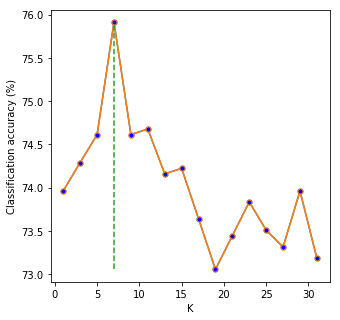

In [28]:
plt.plot(k_list, scores, '-o', markerfacecolor='b', markersize=5)
plt.xlabel('K')
plt.ylabel('Classification accuracy (%)')
axes = plt.gca()
# axes.set_ylim([25, 35])
plt.plot([best_K, best_K], [min(scores), max(scores)], '--')
plt.rcParams['figure.figsize'] = (5,5) 
plt.show()

## Question 2.b:

In [56]:
c_list = [0.1, 0.5, 1, 2, 5, 10, 20, 50]
sigma_list = [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]
scores = np.zeros((len(c_list), len(sigma_list)))
predicted_labels = np.zeros((len(c_list), len(sigma_list), len(training_labels)))
for c_index in range(len(c_list)):
    c = c_list[c_index]
    for sigma_index in range(len(sigma_list)):
        sigma = sigma_list[sigma_index]
        gamma = 1/(sigma**2)
        clf = SVC(C=c, gamma=gamma)
        scores_cross_validation = cross_val_score(clf, training_samples, training_labels.ravel(), cv=5)
        scores[c_index, sigma_index] = 100 * scores_cross_validation.mean()
        predicted_labels_cross_validation = cross_val_predict(clf, training_samples, training_labels.ravel(), cv=5)
        predicted_labels[c_index, sigma_index, :] = predicted_labels_cross_validation
print(scores)
print(predicted_labels[1, 1, :])

[[ 52.33767261  52.33767261  52.33767261  52.33767261  52.33767261
   52.33767261  53.76624951  84.4861414 ]
 [ 53.24634596  53.24634596  53.24634596  53.37621609  53.63616923
   54.54589469  84.67631106  86.04332619]
 [ 58.05134705  58.05134705  58.05134705  58.05134705  59.28553905
   60.90870827  87.40464958  87.21195132]
 [ 58.05134705  58.05134705  58.05134705  58.05134705  59.67514944
   61.62299809  88.25028602  87.92519041]
 [ 58.05134705  58.05134705  58.05134705  58.05134705  59.67514944
   61.62299809  88.31501094  88.83449557]
 [ 58.05134705  58.05134705  58.05134705  58.05134705  59.67514944
   61.62299809  88.31501094  88.89921775]
 [ 58.05134705  58.05134705  58.05134705  58.05134705  59.67514944
   61.62299809  88.31501094  89.09550081]
 [ 58.05134705  58.05134705  58.05134705  58.05134705  59.67514944
   61.62299809  88.31501094  89.09550081]]
[ 1.  1.  1. ...,  1.  1.  1.]


In [52]:
max_accuracy_indices = np.unravel_index(np.argmax(scores, axis=None), scores.shape)
# see: https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html
best_c = c_list[max_accuracy_indices[0]]
best_sigma = sigma_list[max_accuracy_indices[1]]
accuracy_using_best_parameters = scores[max_accuracy_indices[0], max_accuracy_indices[1]]
print(best_c)
print(best_sigma)
print(accuracy_using_best_parameters)

20
10
89.0955008118


#### plotting all ROC curves:

In [82]:
epsilon = 10**(-5)
True_positive_rate = np.zeros((len(c_list), len(sigma_list)))
False_positive_rate = np.zeros((len(c_list), len(sigma_list)))
for c_index in range(len(c_list)):
    for sigma_index in range(len(sigma_list)):
        Positive = sum(training_labels == 1)
        True_Positive = sum((predicted_labels[c_index, sigma_index, :] == 1) & (training_labels == 1).ravel())
        True_positive_rate[c_index, sigma_index] = True_Positive / Positive
        
        Negative = sum(training_labels == -1)
        False_Positive = sum((predicted_labels[c_index, sigma_index, :] == 1) & (training_labels == -1).ravel())
        False_positive_rate[c_index, sigma_index] = False_Positive / Negative
disp_array_beautiful(numpy_array=True_positive_rate, number_of_rows=10)
disp_array_beautiful(numpy_array=False_positive_rate, number_of_rows=10)

,0,1,2,3,4,5,6,7
0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.842432
1,1.0,1.0,1.0,1.0,1.0,1.0,0.936725,0.851117
2,1.0,1.0,1.0,1.0,1.0,1.0,0.919355,0.859801
3,1.0,1.0,1.0,1.0,1.0,1.0,0.916873,0.864764
4,1.0,1.0,1.0,1.0,1.0,1.0,0.918114,0.875931
5,1.0,1.0,1.0,1.0,1.0,1.0,0.918114,0.872208
6,1.0,1.0,1.0,1.0,1.0,1.0,0.918114,0.874690
7,1.0,1.0,1.0,1.0,1.0,1.0,0.918114,0.874690


,0,1,2,3,4,5,6,7
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.970027,0.152589
1,0.980926,0.980926,0.980926,0.978202,0.972752,0.953678,0.252044,0.129428
2,0.880109,0.880109,0.880109,0.880109,0.854223,0.820163,0.175749,0.114441
3,0.880109,0.880109,0.880109,0.880109,0.846049,0.805177,0.155313,0.104905
4,0.880109,0.880109,0.880109,0.880109,0.846049,0.805177,0.155313,0.098093
5,0.880109,0.880109,0.880109,0.880109,0.846049,0.805177,0.155313,0.092643
6,0.880109,0.880109,0.880109,0.880109,0.846049,0.805177,0.155313,0.091281
7,0.880109,0.880109,0.880109,0.880109,0.846049,0.805177,0.155313,0.091281


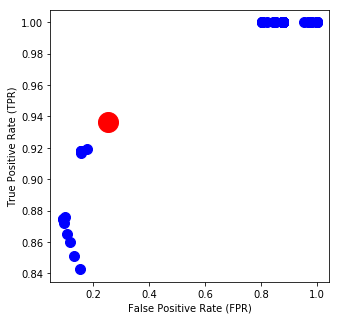

In [88]:
for c_index in range(len(c_list)):
    for sigma_index in range(len(sigma_list)):
        plt.plot(False_positive_rate[c_index, sigma_index], True_positive_rate[c_index, sigma_index], \
                 'ob', markerfacecolor='b', markersize=10)
        if c_index == 1 and sigma_index == 6:
            plt.plot(False_positive_rate[c_index, sigma_index], True_positive_rate[c_index, sigma_index], \
                 'or', markerfacecolor='r', markersize=20)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
axes = plt.gca()
plt.rcParams['figure.figsize'] = (5,5) 
plt.show()

## Question 3.a:

In [96]:
print(training_labels.ravel().shape)
print(precited_labels.shape)

(1540,)
(660,)


In [117]:
warnings.filterwarnings('ignore')
# KNeighborsClassifier
clf_KNeighborsClassifier = KNeighborsClassifier(n_neighbors=best_K)
clf_KNeighborsClassifier.fit(training_samples, training_labels)  
precited_labels_KNN = clf_KNeighborsClassifier.predict(testing_samples)
accuracy_KNN = accuracy_score(y_true=testing_labels, y_pred=precited_labels_KNN)

# SVM Classifier
clf_SVM = SVC(C=best_c, gamma=best_sigma)
clf_SVM.fit(training_samples, training_labels.ravel())  
precited_labels_SVM = clf_SVM.predict(testing_samples)
accuracy_SVM = accuracy_score(y_true=testing_labels, y_pred=precited_labels_SVM)

# RandomForest Classifier
clf_RandomForest = RandomForestClassifier(min_samples_leaf=1, min_samples_split =10, max_features=10)
clf_RandomForest.fit(training_samples, training_labels.ravel())
precited_labels_RandomForest = clf_RandomForest.predict(testing_samples)
accuracy_RandomForest = accuracy_score(y_true=testing_labels, y_pred=precited_labels_RandomForest)

# NeuralNetworks Classifier
clf_NeuralNetworks = MLPClassifier(activation='tanh', solver='sgd',hidden_layer_sizes=(10,))
clf_NeuralNetworks.fit(training_samples, training_labels.ravel())  
precited_labels_NN = clf_NeuralNetworks.predict(testing_samples)
accuracy_NN = accuracy_score(y_true=testing_labels, y_pred=precited_labels_NN)

print('Accuracy rate of KNN: ' + str(accuracy_KNN * 100))
print('Accuracy rate of SVM: ' + str(accuracy_SVM * 100))
print('Accuracy rate of Random Forest: ' + str(accuracy_RandomForest * 100))
print('Accuracy rate of Neural Network: ' + str(accuracy_NN * 100))

Accuracy rate of KNN: 75.6060606061
Accuracy rate of SVM: 59.0909090909
Accuracy rate of Random Forest: 94.696969697
Accuracy rate of Neural Network: 82.5757575758


## Question 3.b:

In [120]:
min_samples_leaf_list = range(1, 20, 4)
min_samples_split_list = range(5, 25, 5)
max_features_list = range(5, 30, 5)
n_estimators_list = range(5, 50, 10)

best_accuracy_RandomForest = -1 * np.inf
for n_estimators in n_estimators_list:
    for min_samples_leaf in min_samples_leaf_list:
        for min_samples_split in min_samples_split_list:
            for max_features in max_features_list:
                clf_RandomForest = RandomForestClassifier(min_samples_leaf=min_samples_leaf, \
                                                          min_samples_split =min_samples_split, \
                                                          max_features=max_features, n_estimators=n_estimators)
                clf_RandomForest.fit(training_samples, training_labels.ravel())
                precited_labels_RandomForest = clf_RandomForest.predict(testing_samples)
                accuracy_RandomForest = accuracy_score(y_true=testing_labels, y_pred=precited_labels_RandomForest)
                if accuracy_RandomForest > best_accuracy_RandomForest:
                    best_accuracy_RandomForest = accuracy_RandomForest
                    best_min_samples_leaf = min_samples_leaf
                    best_min_samples_split = min_samples_split
                    best_max_features = max_features
                    best_n_estimators = n_estimators
print(best_accuracy_RandomForest)
print(best_min_samples_leaf)
print(best_min_samples_split)
print(best_max_features)
print(best_n_estimators)







0.962121212121
1
20
25
45


In [143]:
# F measure: https://en.wikipedia.org/wiki/F1_score
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
accuracy_KNN = []; precision_KNN = []; recall_KNN = []; F_measure_KNN = []
accuracy_SVM = []; precision_SVM = []; recall_SVM = []; F_measure_SVM = []
accuracy_RF = []; precision_RF = []; recall_RF = []; F_measure_RF = []
accuracy_NN = []; precision_NN = []; recall_NN = []; F_measure_NN = []
training_time_KNN = []; classification_time_KNN = [];
training_time_SVM = []; classification_time_SVM = [];
training_time_RF = []; classification_time_RF = [];
training_time_NN = []; classification_time_NN = [];
for classifier in ['KNN', 'SVM', 'RF', 'NN']:
    for run_index in range(1,21):
        training_samples, testing_samples, training_labels, testing_labels = \
        partition_dataset_into_training_and_testing_sets(dataset=dataB_fea, labels=dataB_gnd, fraction_of_training_set=0.7)
        
        if classifier == 'KNN':
            clf_KNeighborsClassifier = KNeighborsClassifier(n_neighbors=best_K)
            start_timer = timeit.default_timer()
            clf_KNeighborsClassifier.fit(training_samples, training_labels)  
            stop_timer = timeit.default_timer()
            training_time_KNN.append(stop_timer - start_timer)
            start_timer = timeit.default_timer()
            precited_labels_KNN = clf_KNeighborsClassifier.predict(testing_samples)
            stop_timer = timeit.default_timer()
            classification_time_KNN.append(stop_timer - start_timer)
            accuracy_KNN.append(accuracy_score(y_true=testing_labels, y_pred=precited_labels_KNN))
            precision, recall, F_measure, _ = precision_recall_fscore_support(y_true=testing_labels , y_pred=precited_labels_KNN)
            precision_KNN.append(precision)
            recall_KNN.append(recall)
            F_measure_KNN.append(F_measure)
        elif classifier == 'SVM':
            clf_SVM = SVC(C=best_c, gamma=best_sigma)
            start_timer = timeit.default_timer()
            clf_SVM.fit(training_samples, training_labels.ravel())  
            stop_timer = timeit.default_timer()
            training_time_SVM.append(stop_timer - start_timer)
            start_timer = timeit.default_timer()
            precited_labels_SVM = clf_SVM.predict(testing_samples)
            stop_timer = timeit.default_timer()
            classification_time_SVM.append(stop_timer - start_timer)
            accuracy_SVM.append(accuracy_score(y_true=testing_labels, y_pred=precited_labels_SVM))
            precision, recall, F_measure, _ = precision_recall_fscore_support(y_true=testing_labels , y_pred=precited_labels_SVM)
            precision_SVM.append(precision)
            recall_SVM.append(recall)
            F_measure_SVM.append(F_measure)
        elif classifier == 'RF':
            clf_RandomForest = RandomForestClassifier(min_samples_leaf=best_min_samples_leaf, \
                                                      min_samples_split =best_min_samples_split, \
                                                      max_features=best_max_features, n_estimators=best_n_estimators)
            start_timer = timeit.default_timer()
            clf_RandomForest.fit(training_samples, training_labels.ravel())
            stop_timer = timeit.default_timer()
            training_time_RF.append(stop_timer - start_timer)
            start_timer = timeit.default_timer()
            precited_labels_RF = clf_RandomForest.predict(testing_samples)
            stop_timer = timeit.default_timer()
            classification_time_RF.append(stop_timer - start_timer)
            accuracy_RF.append(accuracy_score(y_true=testing_labels, y_pred=precited_labels_RF))
            precision, recall, F_measure, _ = precision_recall_fscore_support(y_true=testing_labels , y_pred=precited_labels_RF)
            precision_RF.append(precision)
            recall_RF.append(recall)
            F_measure_RF.append(F_measure)
        elif classifier == 'NN':
            clf_NeuralNetworks = MLPClassifier(activation='tanh', solver='sgd',hidden_layer_sizes=(10,))
            start_timer = timeit.default_timer()
            clf_NeuralNetworks.fit(training_samples, training_labels.ravel())  
            stop_timer = timeit.default_timer()
            training_time_NN.append(stop_timer - start_timer)
            start_timer = timeit.default_timer()
            precited_labels_NN = clf_NeuralNetworks.predict(testing_samples)
            stop_timer = timeit.default_timer()
            classification_time_NN.append(stop_timer - start_timer)
            accuracy_NN.append(accuracy_score(y_true=testing_labels, y_pred=precited_labels_NN))
            precision, recall, F_measure, _ = precision_recall_fscore_support(y_true=testing_labels , y_pred=precited_labels_NN)
            precision_NN.append(precision)
            recall_NN.append(recall)
            F_measure_NN.append(F_measure)

# KNN averaging and standard deviation:
average_accuracy_KNN = (np.asarray(accuracy_KNN) * 100).mean()
std_accuracy_KNN = (np.asarray(accuracy_KNN) * 100).std()
average_precision_KNN = (np.asarray(precision_KNN) * 100).mean()
std_precision_KNN = (np.asarray(precision_KNN) * 100).std()
average_recall_KNN = (np.asarray(recall_KNN) * 100).mean()
std_recall_KNN = (np.asarray(recall_KNN) * 100).std()
average_F_measure_KNN = (np.asarray(F_measure_KNN) * 100).mean()
std_F_measure_KNN = (np.asarray(F_measure_KNN) * 100).std()
average_training_time_KNN = (np.asarray(training_time_KNN) * 100).mean()
average_classification_time_KNN = (np.asarray(classification_time_KNN) * 100).mean()

print(average_accuracy_KNN)
print(std_accuracy_KNN)
print(average_precision_KNN)
print(std_precision_KNN)
print(average_recall_KNN)
print(std_recall_KNN)
print(average_F_measure_KNN)
print(std_F_measure_KNN)
print('**************************')
print(average_training_time_KNN)
print(average_classification_time_KNN)

# SVM averaging and standard deviation:
average_accuracy_SVM = (np.asarray(accuracy_SVM) * 100).mean()
std_accuracy_SVM = (np.asarray(accuracy_SVM) * 100).std()
average_precision_SVM = (np.asarray(precision_SVM) * 100).mean()
std_precision_SVM = (np.asarray(precision_SVM) * 100).std()
average_recall_SVM = (np.asarray(recall_SVM) * 100).mean()
std_recall_SVM = (np.asarray(recall_SVM) * 100).std()
average_F_measure_SVM = (np.asarray(F_measure_SVM) * 100).mean()
std_F_measure_SVM = (np.asarray(F_measure_SVM) * 100).std()
average_training_time_SVM = (np.asarray(training_time_SVM) * 100).mean()
average_classification_time_SVM = (np.asarray(classification_time_SVM) * 100).mean()

print(average_accuracy_SVM)
print(std_accuracy_SVM)
print(average_precision_SVM)
print(std_precision_SVM)
print(average_recall_SVM)
print(std_recall_SVM)
print(average_F_measure_SVM)
print(std_F_measure_SVM)
print('**************************')
print(average_training_time_SVM)
print(average_classification_time_SVM)

# RF averaging and standard deviation:
average_accuracy_RF = (np.asarray(accuracy_RF) * 100).mean()
std_accuracy_RF = (np.asarray(accuracy_RF) * 100).std()
average_precision_RF = (np.asarray(precision_RF) * 100).mean()
std_precision_RF = (np.asarray(precision_RF) * 100).std()
average_recall_RF = (np.asarray(recall_RF) * 100).mean()
std_recall_RF = (np.asarray(recall_RF) * 100).std()
average_F_measure_RF = (np.asarray(F_measure_RF) * 100).mean()
std_F_measure_RF = (np.asarray(F_measure_RF) * 100).std()
average_training_time_RF = (np.asarray(training_time_RF) * 100).mean()
average_classification_time_RF = (np.asarray(classification_time_RF) * 100).mean()

print(average_accuracy_RF)
print(std_accuracy_RF)
print(average_precision_RF)
print(std_precision_RF)
print(average_recall_RF)
print(std_recall_RF)
print(average_F_measure_RF)
print(std_F_measure_RF)
print('**************************')
print(average_training_time_RF)
print(average_classification_time_RF)

# NN averaging and standard deviation:
average_accuracy_NN = (np.asarray(accuracy_NN) * 100).mean()
std_accuracy_NN = (np.asarray(accuracy_NN) * 100).std()
average_precision_NN = (np.asarray(precision_NN) * 100).mean()
std_precision_NN = (np.asarray(precision_NN) * 100).std()
average_recall_NN = (np.asarray(recall_NN) * 100).mean()
std_recall_NN = (np.asarray(recall_NN) * 100).std()
average_F_measure_NN = (np.asarray(F_measure_NN) * 100).mean()
std_F_measure_NN = (np.asarray(F_measure_NN) * 100).std()
average_training_time_NN = (np.asarray(training_time_NN) * 100).mean()
average_classification_time_NN = (np.asarray(classification_time_NN) * 100).mean()

print(average_accuracy_NN)
print(std_accuracy_NN)
print(average_precision_NN)
print(std_precision_NN)
print(average_recall_NN)
print(std_recall_NN)
print(average_F_measure_NN)
print(std_F_measure_NN)
print('**************************')
print(average_training_time_NN)
print(average_classification_time_NN)
    
    

73.4090909091
0.833333333333
79.5273239734
14.8260526712
74.5692800549
21.9542469568
72.5138833646
5.07436238853
**************************
0.396128305181
8.2218391345
58.8636363636
0.0757575757576
77.8358382027
22.1648335684
57.4374662146
42.5713347232
48.7010006876
22.8612856515
**************************
26.9187806201
8.7628282336
95.3787878788
0.530303030303
95.3593417554
2.20148127196
95.4750002638
1.99865716257
95.3742416641
0.543262477294
**************************
14.8855680841
0.533986914689
83.5606060606
0.227272727273
83.5685647245
1.94523526092
83.6111207605
1.41967763833
83.5563895047
0.351070339169
**************************
55.0772624008
0.0382885403212


In [141]:
start = timeit.default_timer()

#Your statements here

stop = timeit.default_timer()

print(stop - start)

2.781009413716865e-05
